# Bachelorthesis
## Feature Engineering

Im folgenden werde ich einen Datensatz Step by Step für Machine Learning aufbereiten.<br>
Es wird der durch die Datenbank gelieferte Datensatz als Ground Zero verwendet. Auf die Datenbeschaffung und rudimentäre aufbereitung wird nicht eingegangen.
Ziel soll es sein durch jeden Schritt die Performance eines darauf ausetztenden Modells zu steigern.
Die Anwendung unterscheidlicher Modelle findet in einem Zweiten Notebook statt.<br>
Am Ende jeden Kapitels wird der Datensatz gespeichert und kann an dieser stelle auch wieder geladen werden.




<h1>Table of Contents</h1>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Bibliotheken" data-toc-modified-id="Bibliotheken-1">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                        Bibliotheken
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#DB_Connection" data-toc-modified-id="DB_Connection">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                        Connection to Database.
                </a>
            </span>
        </li>
        <li>
            <span>
            <a href="#Kunde_Tarifschlüssel " data-toc-modified-id="Kunde_Tarifschlüssel ">
            <span class="toc-item-num">3&nbsp;&nbsp;</span>
            Kunde-->Tarifschlüssel 
            </a>
            </span>
        </li>
        <li>
            <span>
            <a href="#Partner_WZ_Schlüssel" data-toc-modified-id="Partner_WZ_Schlüssel">
            <span class="toc-item-num">4&nbsp;&nbsp;</span>
            Partner --> WZ-Schlüssel
            </a>
            </span>
        </li>
        <li>
            <span>
            <a href="#Ausgangsdatensatz" data-toc-modified-id="Ausgangsdatensatz">
            <span class="toc-item-num">5&nbsp;&nbsp;</span>
                Ausgangsdatensatz
            </a>
            </span>
        </li>
        <li>
            <span>
            <a href="#One_Hot_Encodet" data-toc-modified-id="One_Hot_Encodet">
            <span class="toc-item-num">6&nbsp;&nbsp;</span>
                One Hot Encodet Tarifschlüssel
            </a>
            </span>
        </li>
        <li>
            <span>
            <a href="#Transform_WZ_to_Vec" data-toc-modified-id="Transform_WZ_to_Vec">
            <span class="toc-item-num">7&nbsp;&nbsp;</span>
                 Transform WZ to Vec
            </a>
            </span>
        </li>
        
        <li>
            <span>
            <a href="#Network_Embedding_Partner" data-toc-modified-id="Network_Embedding_Partner">
            <span class="toc-item-num">7&nbsp;&nbsp;</span>
                 Network Embedding Partner
            </a>
            </span>
        </li>
    </ul>
</div>

## Bibliotheken

In [ ]:
#Lib to connect to database 
#import psycopg2
#print('psycopg2 ',psycopg2.__version__)

#Lib for storing and process data internally
import pandas as pd
print('Pandas ',pd.__version__)

#lib to convert string to hash
import hashlib

#support for large, multi-dimensional arrays and matrices
import numpy as np
print('numpy ',np.__version__)

#tool for show progress bars in 
from tqdm import tqdm 

#Lib for handling sparse Matrix
import scipy 
from scipy.sparse import coo_matrix, vstack,csr_matrix,hstack,save_npz,load_npz
print('scipy ', scipy.__version__)

#Used for transforming to One Hot Vector
import sklearn
from sklearn.preprocessing import OneHotEncoder
print('sklearn ',sklearn.__version__)

#Lib for Handling networks
import networkx as nx#
print('networkx', nx.__version__)

#Lib for drawing Plots and Graphs
import matplotlib.pyplot as plt

#Lib for do Network Embedding
from node2vec import Node2Vec

#Lib use for store wordvectors
from gensim.models import KeyedVectors

## DB_Connection
Die Zugangsdaten werden gelöscht aber alle Daten liegen Datein am Ende jedes Kapitels im Zugriff.

In [4]:
dsn_database = "XXXX"
dsn_hostname = "XXXX"
dsn_port = 'XXX'
dsn_uid = "XXXX"
dsn_pwd = "XXXXX"

conn_str = "host=" + dsn_hostname \
     + " dbname=" + dsn_database + " user=" + dsn_uid + " password=" + dsn_pwd

try:
    conn = psycopg2.connect(conn_str)
    print('Connected to database')
except:
    print('Unable to connect to database')

Connected to database


### Kunde_Tarifschlüssel 
Im ersten Schritt werden die Daten aus der Datenbank geholt. Hierbei handelt es sich um den Datensatz Kunde--> Tarifschlüssel. <br>
Ein Kunde wird durch eine partner_nr repräsentiert, die durch einen Hashwert ersetzt wird. <br>
Zusätzlich zu den Tarifschlüssel ist die Untergruppe des WZ-Schlüssel für einen Kunden in der Spalte wz_2008_hauptcode soweit vorhanden. <br> <br>

Am Ende des Abschnittes liegt der berreinigte Datensatz Kunde Tarifschlüssel vor und wird als Pickle File gespeichert

In [5]:
with conn.cursor() as cursor:

            cursor.execute("SELECT partner_nr,lvtvkz,wkz_schl,betriebsart,wz_2008_hauptcode FROM diffusion_model.feature_set");
            column_names = [desc[0] for desc in cursor.description]

            feature = pd.DataFrame(cursor.fetchall(),columns=column_names)

feature['partner_nr'] =feature['partner_nr'].apply(lambda x: hashlib.md5(str(x).encode('utf-8')).hexdigest())  

In [6]:
feature.describe(include ='all')[:2][['partner_nr', 'lvtvkz','wkz_schl','betriebsart']]

,partner_nr,lvtvkz,wkz_schl,betriebsart
count,639670,120677,356620,127605
unique,499510,159,3094,1635


In [7]:
#Ein Abzug Aller Partner 
feature_all = feature.copy()
# Die Partner_Nr wird als index für das Pandas Date Frame genutzt 
feature=feature.reset_index().set_index('partner_nr')
# Ersetzt alle Felder der Tabelle durch 0 sollten sie keine Wert haben. Dies werleichter die Verarbeitung im folgeden. 
feature = feature.fillna(0) 
# Alle Einträge ohne einen wz Schlüssel werden gelöscht weil sie im rahmen von Supervised Learning nicht benötigt werde.
# Im Rahmen eines Semi Supervied Learning Projektes auf den Daten könnten diese grioße Menge ungenutzter information wieder relevant werden
feature = feature[ feature.wz_2008_hauptcode !=0] 
print('Anzahl Zeilen und Spalten', feature.shape)
feature.head(5)

Anzahl Zeilen und Spalten (149980, 5)


,index,lvtvkz,wkz_schl,betriebsart,wz_2008_hauptcode
partner_nr,,,,,
4290392ffe7d0f59a20e5a2645b2ae1c,0,0,0,0,47250
ca525070f389020b42436b4ef5f51722,2,0,1533 18 3,0,43912
1aa0928cb4f6ef9f1dc2c55b45c7815f,7,0,6501 01 1,0,70109
ff63d360b81486502aa71e8310a8555b,10,0,0,Z021,32503
ff63d360b81486502aa71e8310a8555b,11,0,1292 00 0,0,32503


In [8]:
feature_tarif = feature[['lvtvkz','wkz_schl','betriebsart']]
feature_tarif.head(6)

,lvtvkz,wkz_schl,betriebsart
partner_nr,,,
4290392ffe7d0f59a20e5a2645b2ae1c,0,0,0
ca525070f389020b42436b4ef5f51722,0,1533 18 3,0
1aa0928cb4f6ef9f1dc2c55b45c7815f,0,6501 01 1,0
ff63d360b81486502aa71e8310a8555b,0,0,Z021
ff63d360b81486502aa71e8310a8555b,0,1292 00 0,0
78c9a06231f512d2f5a140900da15992,0,1281 10 1,0


In [9]:
feature_tarif.to_pickle('data/partner_tarif.p')

In [10]:
feature_tarif=pd.read_pickle('data/partner_tarif.p')

### Partner_WZ_Schlüssel
In diesem Abschnitt wird einem Kunden Wirtschaftszweig aus "Klassifikation der Wirtschaftszweige" zugeordnet und ein erster Zielvektor erstellt.

Zuerst wird eine Tabelle geladen in der der die Systematik der Wirtschaftzweige abgelegt ist. 

In [11]:
with conn.cursor() as cursor:

            cursor.execute("SELECT * FROM diffusion_model.wz_schluessel_hierarchisch");
            column_names = [desc[0] for desc in cursor.description]

            wz_schlüssel = pd.DataFrame(cursor.fetchall(),columns=column_names)
print(wz_schlüssel.shape)
wz_schlüssel.head(5)

(839, 18)


,e_1,e_1_text,e_2,e_2_text,e_3,e_3_text,e_4,e_4_text,e_5,e_5_text,id_hierarchisch,id,ebene,e_2_hierarchisch,e_3_hierarchisch,e_4_hierarchisch,e_5_hierarchisch,id_text
0,A,"LAND- UND FORSTWIRTSCHAFT, FISCHEREI",01,"Landwirtschaft, Jagd und damit verbundene Täti...",1,Anbau einjähriger Pflanzen,11,"Anbau von Getreide (ohne Reis), Hülsenfrüchten...",0,"Anbau von Getreide (ohne Reis), Hülsenfrüchten...",A.01.1.11.0,01110,5,A.01,A.01.1,A.01.1.11,A.01.1.11.0,"Anbau von Getreide (ohne Reis), Hülsenfrüchten..."
1,A,"LAND- UND FORSTWIRTSCHAFT, FISCHEREI",01,"Landwirtschaft, Jagd und damit verbundene Täti...",1,Anbau einjähriger Pflanzen,12,Anbau von Reis,0,Anbau von Reis,A.01.1.12.0,01120,5,A.01,A.01.1,A.01.1.12,A.01.1.12.0,Anbau von Reis
2,A,"LAND- UND FORSTWIRTSCHAFT, FISCHEREI",01,"Landwirtschaft, Jagd und damit verbundene Täti...",1,Anbau einjähriger Pflanzen,13,Anbau von Gemüse und Melonen sowie Wurzeln und...,1,Anbau von Gemüse und Melonen,A.01.1.13.1,01131,5,A.01,A.01.1,A.01.1.13,A.01.1.13.1,Anbau von Gemüse und Melonen
3,A,"LAND- UND FORSTWIRTSCHAFT, FISCHEREI",01,"Landwirtschaft, Jagd und damit verbundene Täti...",1,Anbau einjähriger Pflanzen,13,Anbau von Gemüse und Melonen sowie Wurzeln und...,2,Anbau von Kartoffeln sowie sonstigen Wurzeln u...,A.01.1.13.2,01132,5,A.01,A.01.1,A.01.1.13,A.01.1.13.2,Anbau von Kartoffeln sowie sonstigen Wurzeln u...
4,A,"LAND- UND FORSTWIRTSCHAFT, FISCHEREI",01,"Landwirtschaft, Jagd und damit verbundene Täti...",1,Anbau einjähriger Pflanzen,14,Anbau von Zuckerrohr,0,Anbau von Zuckerrohr,A.01.1.14.0,01140,5,A.01,A.01.1,A.01.1.14,A.01.1.14.0,Anbau von Zuckerrohr


In [12]:
wz_desc = wz_schlüssel.describe()[:2][['e_1','e_2_hierarchisch','e_3_hierarchisch','e_4_hierarchisch','e_5_hierarchisch']]
wz_desc.columns =['Abschnitte', 'Abteilungen', 'Gruppen', 'Klassen','Unterklassen']
wz_desc

,Abschnitte,Abteilungen,Gruppen,Klassen,Unterklassen
count,839,839,839,839,839
unique,21,88,272,615,839


In [13]:
wz_schlüssel['id'] = wz_schlüssel['id'].astype(int)
wz_schlüssel=wz_schlüssel.set_index('id')  
wz_hir=wz_schlüssel[['e_1','e_2_hierarchisch','e_3_hierarchisch','e_4_hierarchisch','e_5_hierarchisch']]

In [15]:
feature['wz_2008_hauptcode'] = feature['wz_2008_hauptcode'].astype(int) 
target_wz=feature.join(wz_hir,on='wz_2008_hauptcode',how='left',rsuffix ='_wz')

In [16]:
target_wz=target_wz.reset_index()#.set_index('partner_nr')#['e_1','e_2_hierarchisch','e_3_hierarchisch','e_4_hierarchisch','e_5_hierarchisch']
target_wz=target_wz[['partner_nr','e_1','e_2_hierarchisch','e_3_hierarchisch','e_4_hierarchisch','e_5_hierarchisch']]
target_wz.head(5)

,partner_nr,e_1,e_2_hierarchisch,e_3_hierarchisch,e_4_hierarchisch,e_5_hierarchisch
0,4290392ffe7d0f59a20e5a2645b2ae1c,G,G.47,G.47.2,G.47.2.25,G.47.2.25.0
1,ca525070f389020b42436b4ef5f51722,F,F.43,F.43.9,F.43.9.91,F.43.9.91.2
2,1aa0928cb4f6ef9f1dc2c55b45c7815f,M,M.70,M.70.1,M.70.1.10,M.70.1.10.9
3,ff63d360b81486502aa71e8310a8555b,C,C.32,C.32.5,C.32.5.50,C.32.5.50.3
4,ff63d360b81486502aa71e8310a8555b,C,C.32,C.32.5,C.32.5.50,C.32.5.50.3


In [118]:
target_wz.describe()#[:2]

,e_1,e_2_hierarchisch,e_3_hierarchisch,e_4_hierarchisch,e_5_hierarchisch
count,149980,149980,149980,149980,149980
unique,20,83,248,541,713
top,G,F.43,F.43.9,F.43.9.91,F.43.9.91.2
freq,39580,36146,14428,10372,7874


In [18]:
target_wz.to_pickle('data/partner_wz.p')

In [80]:
target_wz=pd.read_pickle('data/partner_wz.p')

### Ausgangsdatensatz
An dieser Stelle des Notebooks steht der vollständige Ausgangsadtansatz bereit und ist als Datei abgelegt.

In [35]:
target_wz = target_wz.set_index('partner_nr')
target_wz.head(3)

,e_1,e_2_hierarchisch,e_3_hierarchisch,e_4_hierarchisch,e_5_hierarchisch
partner_nr,,,,,
4290392ffe7d0f59a20e5a2645b2ae1c,G,G.47,G.47.2,G.47.2.25,G.47.2.25.0
ca525070f389020b42436b4ef5f51722,F,F.43,F.43.9,F.43.9.91,F.43.9.91.2
1aa0928cb4f6ef9f1dc2c55b45c7815f,M,M.70,M.70.1,M.70.1.10,M.70.1.10.9


In [36]:
feature_tarif.head(3)

,lvtvkz,wkz_schl,betriebsart
partner_nr,,,
4290392ffe7d0f59a20e5a2645b2ae1c,0,0,0
ca525070f389020b42436b4ef5f51722,0,1533 18 3,0
1aa0928cb4f6ef9f1dc2c55b45c7815f,0,6501 01 1,0


In [37]:
feature_tarif.shape

(149980, 3)

In [42]:
feature_target_one= feature_tarif.join(target_wz).reset_index()
feature_target_one.head(3)

,partner_nr,lvtvkz,wkz_schl,betriebsart,e_1,e_2_hierarchisch,e_3_hierarchisch,e_4_hierarchisch,e_5_hierarchisch
0,0000dce02bc7a4ac9d66d463772ed976,0,0,0,C,C.23,C.23.7,C.23.7.70,C.23.7.70.0
1,00022b6595727f590b36e008c0bf4cf5,0,0,0,K,K.66,K.66.2,K.66.2.29,K.66.2.29.0
2,00033ce81931041312d2772a74cb389f,0,1176 17 0,0,G,G.47,G.47.2,G.47.2.29,G.47.2.29.0


In [43]:
for col in feature_target_one.columns:
    feature_target_one[col] = feature_target_one[col].astype(str)

Zur beschleunigung der Folgenden Entwicklungsschritte wird nur ein Teil der Daten verarbeit. Nach Abgeschlossener Entwicklung werden alle Daten Verarbeitet. 

In [44]:
#feature_target_one = feature_target_one.sample(3000)

## One_Hot_Encodet
In diesem Kapitel werden die Tarifschlüssel als One Hot Encodet Vaktoren codiert.
Jedem Kunden werden mehrere Tarifschlüssel. Unter anderem können auch mehrere Schlüssel pro Schlüssel Type einem Kunden zugeordnet werden. Um dieses Abbilden zu können werden die Daten in One Hot Vektoren abgebildet.

In [45]:
#Zu beginn werden die Kunden in eine Matrix sortiert in der jede Zeile einem Kunden repräsentiert.Jede Spalte korrespondiert
#mit der entsprechenden Zeile in der Feature bzw. Target Matrix. In einer Zeile steht an jeder Stelle die einem Partner zugerrechnet wird eine eins in anderen 0.
#Durch muliplikation mit der Feature Matrix werden alle Einträge eines Kunden summiert. 
# Ein visuelles Beispiel findet sich in der 
f = []
for uniqu_id in tqdm(set(feature_target_one['partner_nr'])):
    f.append(coo_matrix(feature_target_one['partner_nr'].apply(lambda x: 1 if x ==uniqu_id else 0).values.reshape(1,-1)))
partner=vstack(f)
save_npz('data/partnet_groupMatrix.npz', partner)
partner
#csr Matrix

100%|██████████| 95620/95620 [3:31:07<00:00,  7.66it/s]  


<95620x333602 sparse matrix of type '<class 'numpy.int64'>'
	with 333602 stored elements in COOrdinate format>

In [46]:
partner = load_npz('data/partnet_groupMatrix.npz')

In [47]:
enc = OneHotEncoder(dtype=int)

In [48]:
feature_OneHot=enc.fit_transform(feature_target_one[['lvtvkz','wkz_schl','betriebsart']])
feature_OneHot

<333602x3878 sparse matrix of type '<class 'numpy.int32'>'
	with 1000806 stored elements in Compressed Sparse Row format>

In [49]:
#Selektion und summierung von Zeilen die dem Selben Partner zugerrechnet werden
features_OneHot=partner*feature_OneHot
#Bei der Gruppierung können Summen größer 1 entsehen diese werden wieder auf 1 reduziert. Da ein kunde nur eine Ausprägung von einem Tarifschlüssl haben kann.
features_OneHot.data = np.array([int(x/x) if x>0 else int(0) for x in features_OneHot.data ]).astype('int') # auf Wertebereich [0,1] gesetzt
features_OneHot

<95620x3878 sparse matrix of type '<class 'numpy.int32'>'
	with 368071 stored elements in Compressed Sparse Row format>

In [50]:
feature_target_one.head()

,partner_nr,lvtvkz,wkz_schl,betriebsart,e_1,e_2_hierarchisch,e_3_hierarchisch,e_4_hierarchisch,e_5_hierarchisch
0,0000dce02bc7a4ac9d66d463772ed976,0,0,0,C,C.23,C.23.7,C.23.7.70,C.23.7.70.0
1,00022b6595727f590b36e008c0bf4cf5,0,0,0,K,K.66,K.66.2,K.66.2.29,K.66.2.29.0
2,00033ce81931041312d2772a74cb389f,0,1176 17 0,0,G,G.47,G.47.2,G.47.2.29,G.47.2.29.0
3,00033ce81931041312d2772a74cb389f,0,1176 17 0,0,G,G.47,G.47.2,G.47.2.29,G.47.2.29.0
4,00033ce81931041312d2772a74cb389f,0,0,B116,G,G.47,G.47.2,G.47.2.29,G.47.2.29.0


In [51]:
target=feature_target_one.drop_duplicates('partner_nr')[['partner_nr','e_1','e_2_hierarchisch','e_3_hierarchisch','e_4_hierarchisch','e_5_hierarchisch']]

In [53]:
save_npz('data/DataOneHot/OneHotEncodetFeature.npz', features_OneHot)
target.to_pickle('data/DataOneHot/OneHotEncodetTargets.p')

In [57]:
features_OneHot=load_npz('data/DataOneHot/OneHotEncodetFeature.npz')
target=pd.read_pickle('data/DataOneHot/OneHotEncodetTargets.p')

# Transform_WZ_to_Vec
In diesem Kapitel wird der Wirtschaftszweig zu einem Latenten Vektor Überführt. Als Grundlage dafür wird die Anordnung der Wirtschaftzweige in hierarchisch Bäumen verwendet

In [72]:
parent_child=[]
parent_child.append(wz_hir[['e_1','e_2_hierarchisch']])
parent_child.append(wz_hir[['e_2_hierarchisch','e_3_hierarchisch']])
parent_child.append(wz_hir[['e_3_hierarchisch','e_4_hierarchisch']])
parent_child.append(wz_hir[['e_4_hierarchisch','e_5_hierarchisch']])
for df in parent_child:
    df.columns=['parent','child']

parent_child=pd.concat(parent_child)
parent_child=parent_child.drop_duplicates()

In [73]:
wz_edges = [(x[0],x[1])for x in parent_child.values]
wz_edges[:10]

[('A', 'A.01'),
 ('A', 'A.02'),
 ('A', 'A.03'),
 ('B', 'B.05'),
 ('B', 'B.06'),
 ('B', 'B.07'),
 ('B', 'B.08'),
 ('B', 'B.09'),
 ('C', 'C.10'),
 ('C', 'C.11')]

In [74]:
G=nx.Graph(wz_edges)

In [75]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1835
Number of edges: 1814
Average degree:   1.9771


In [76]:
sub_wz_tree=list(nx.connected_component_subgraphs(G))

None


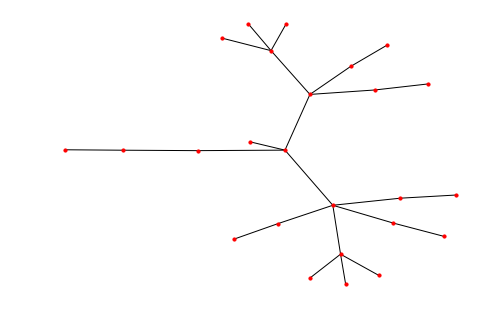

In [77]:
print(nx.draw(
    sub_wz_tree[3]
              ,node_size =10,with_labels=False ))

In [80]:
node2vec = Node2Vec(G,dimensions=3,walk_length=20,num_walks=20,workers=1)
model_3= node2vec.fit(window=10, iter=25)
model_3.wv.save('emb/wz_emb3.p')

Computing transition probabilities: 100%|██████████| 1835/1835 [00:00<00:00, 26214.04it/s]
0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 20/20 [00:21<00:00,  1.11s/it]
1it [00:22, 22.24s/it]


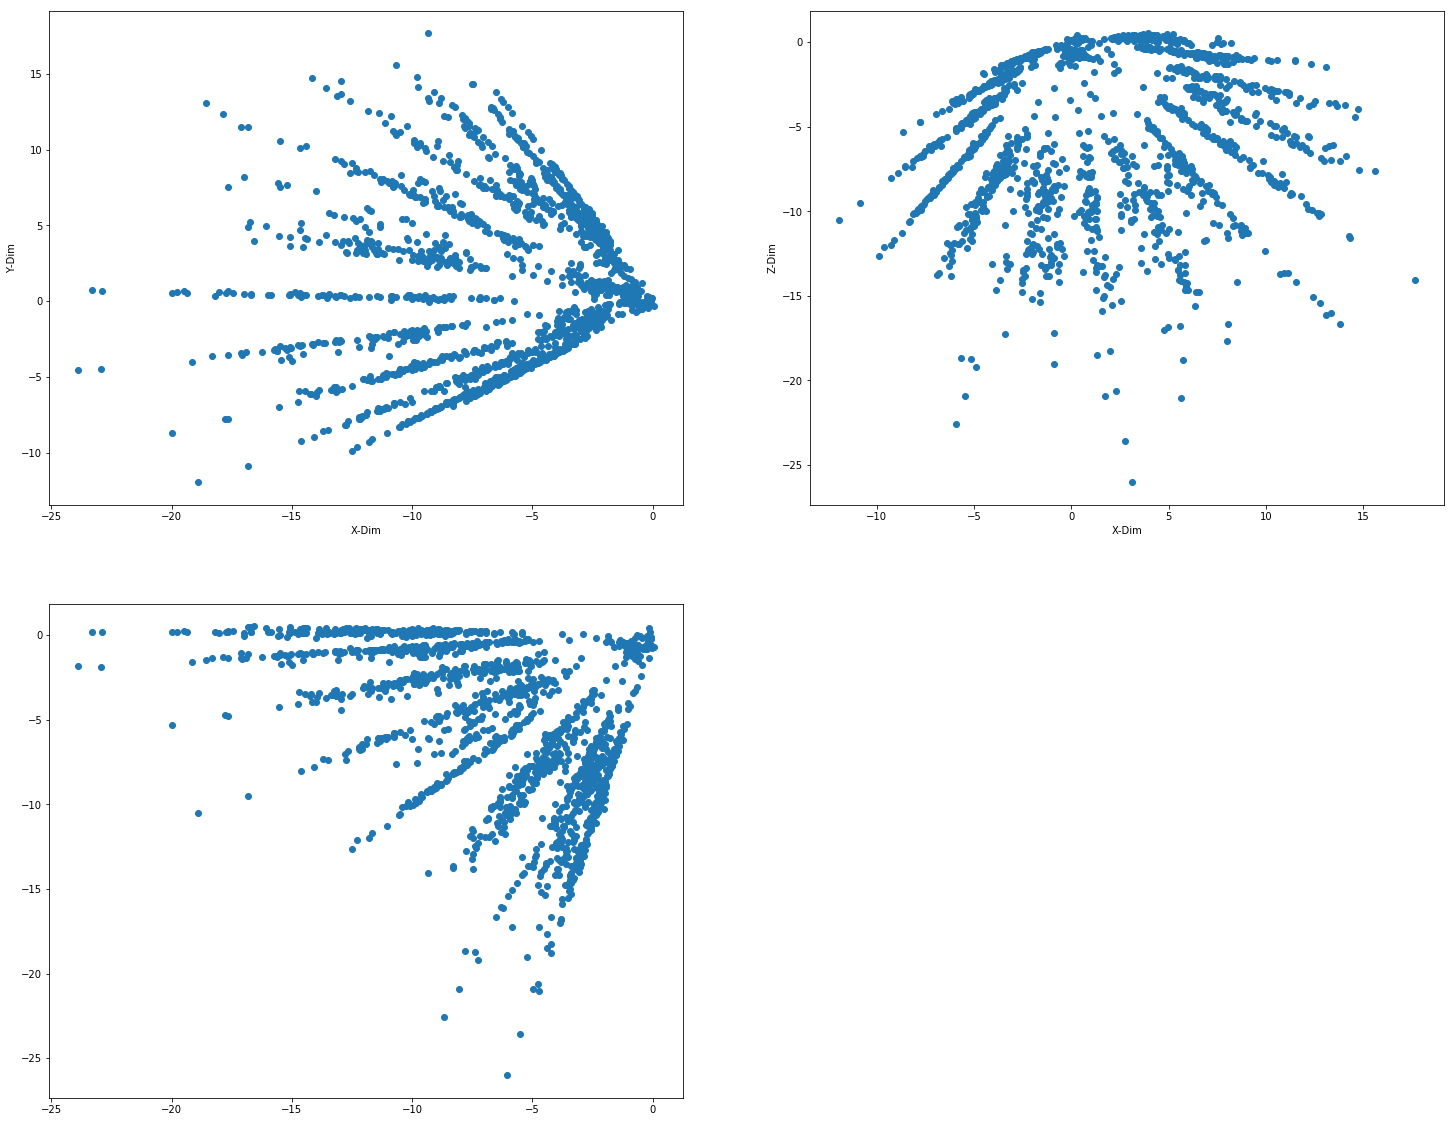

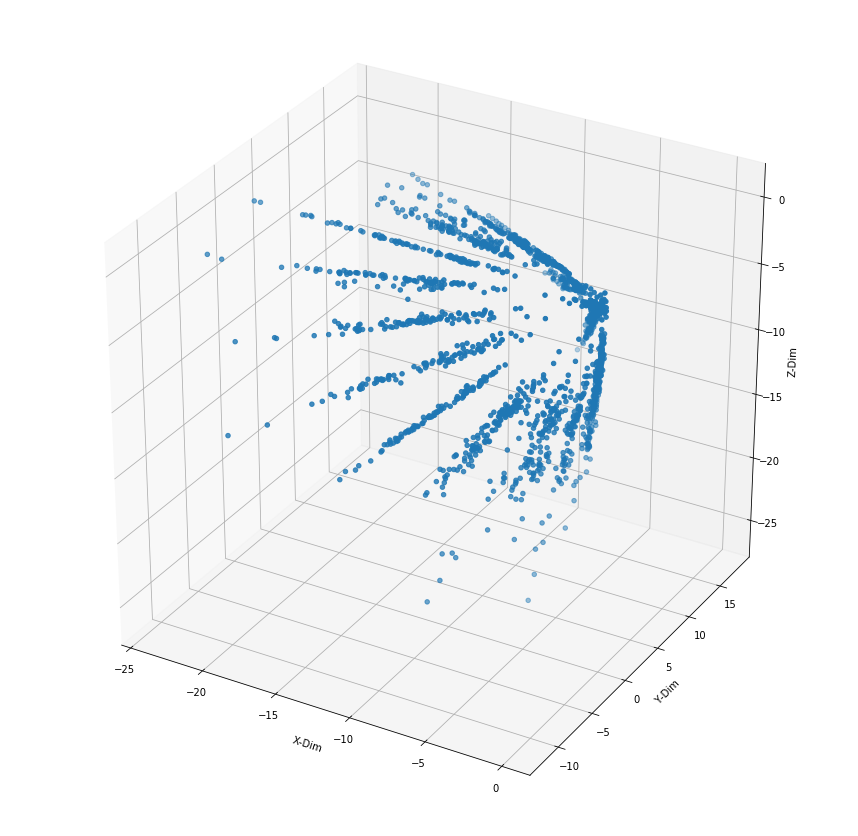

In [81]:
vector_dict={}
for word in list(G):
    vector_dict[word] = model.wv.get_vector(word)
vectors = list(vector_dict.values())

x = []
for v in vectors:
    x.append(v[0])
y = []
for v in vectors:
    y.append(v[1])

z = []
for v in vectors:
    z.append(v[2])
#print(x,y,z)


figure_1 = plt.figure(1, figsize=(25, 20))

chart_1 = figure_1.add_subplot(221)
chart_2 = figure_1.add_subplot(222)
chart_3 = figure_1.add_subplot(223)


chart_1.scatter(x,y)
chart_1.set_xlabel('X-Dim')
chart_1.set_ylabel('Y-Dim')
#chart_1.set_yticklabels(sorted(set(df_name['??']),reverse=True))

chart_2.scatter(y, z)
chart_2.set_xlabel('Y-Dim')
chart_2.set_ylabel('Z-Dim')
#chart_2.set_yticklabels(sorted(set(df_name['??']),reverse=True))

chart_3.scatter(x,z)
chart_2.set_xlabel('X-Dim')
chart_2.set_ylabel('Z-Dim')
#chart_3.set_yticklabels(sorted(set(df_name['??']),reverse=True))




#plt.show()
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('X-Dim')
ax.set_ylabel('Y-Dim')
ax.set_zlabel('Z-Dim')

plt.show()


### Test des Branchen Embeddings
In diesem Teil soll gestetstet werden wie gut das Ebedding der Brache funktioniert hat. Dazu wird ein Analogie Test durchgeführt.

In [257]:
df_test_similar=[]
df_test = wz_hir[['e_1','e_2_hierarchisch']].drop_duplicates()
for l in df_test.as_matrix():
    df = df_test.copy()#
    df = df[df.e_2_hierarchisch != l[1]]
    df['e_1_test']=[l[0] for x in range(87)]
    df['e_2_hierarchisch_test']=[l[1] for x in range(87) ]
    df_test_similar.append(df)
df_test=pd.concat(df_test_similar)  

In [234]:
#hänisches Einfügen von Sektion
df_test.to_csv('Y:/Bachelorarbeit/jupyter/Notebooks_Thesis/emb/test_wz_Abschnitt-Abteilung.csv',sep =' ',header=False, index=False)

In [82]:
res = model_3.wv.evaluate_word_analogies('Y:/Bachelorarbeit/jupyter/Notebooks_Thesis/emb/test_wz.csv')
res[0]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.016588296760710552

In [127]:
node2vec = Node2Vec(G,dimensions=5,walk_length=15,num_walks=20,workers=1)
model_5 = node2vec.fit(window=10, iter=50)
model_5.wv.save('emb/wz_emb30.p')
res = model_5.wv.evaluate_word_analogies('Y:/Bachelorarbeit/jupyter/Notebooks_Thesis/emb/test_wz.csv')
res[0]

Computing transition probabilities: 100%|██████████| 1835/1835 [00:00<00:00, 26214.22it/s]
0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 20/20 [00:15<00:00,  1.24it/s]
1it [00:16, 16.15s/it]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.12722048066875652

In [129]:
node2vec = Node2Vec(G,dimensions=10,walk_length=15,num_walks=20,workers=1)
model_10 = node2vec.fit(window=10, iter=50)
model_10.wv.save('emb/wz_emb30.p')
res = model_10.wv.evaluate_word_analogies('Y:/Bachelorarbeit/jupyter/Notebooks_Thesis/emb/test_wz.csv')
res[0]

Computing transition probabilities: 100%|██████████| 1835/1835 [00:00<00:00, 25137.00it/s]
0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 20/20 [00:16<00:00,  1.14it/s]
1it [00:17, 17.47s/it]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.1509926854754441

In [120]:
node2vec = Node2Vec(G,dimensions=30,walk_length=15,num_walks=20,workers=1)
model_30 = node2vec.fit(window=10, iter=50)
model_30.wv.save('emb/wz_emb30.p')
res = model_30.wv.evaluate_word_analogies('Y:/Bachelorarbeit/jupyter/Notebooks_Thesis/emb/test_wz.csv')
res[0]

Computing transition probabilities: 100%|██████████| 1835/1835 [00:00<00:00, 15818.97it/s]
0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 20/20 [00:21<00:00,  1.16s/it]
1it [00:22, 22.95s/it]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.09077847439916406

In [122]:
node2vec = Node2Vec(G,dimensions=128,walk_length=15,num_walks=20,workers=1)
model_128 = node2vec.fit(window=10, iter=50)
model_128.wv.save('emb/wz_emb128.p')
res = model_128.wv.evaluate_word_analogies('Y:/Bachelorarbeit/jupyter/Notebooks_Thesis/emb/test_wz.csv')
res[0]

Computing transition probabilities: 100%|██████████| 1835/1835 [00:00<00:00, 16531.56it/s]
0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 20/20 [00:22<00:00,  1.18s/it]
1it [00:23, 23.58s/it]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.07066353187042843

In [130]:
vector_dict={}
for word in list(G):
    vector_dict[word] = model_10.wv.get_vector(word)
vectors = list(vector_dict.values())

wz_vec = pd.DataFrame.from_dict(vector_dict, orient='index')
wz_vec.head(5)

,0,1,2,3,4,5,6,7,8,9
A,-6.788249,4.047181,3.086034,-6.673488,-10.888042,1.223517,2.905775,5.390987,-4.569266,0.737593
A.01,-7.301380,7.653089,5.008636,-5.504945,-8.816540,1.898328,-1.392737,12.442822,-11.263078,0.064474
A.02,-5.347321,4.204561,1.920521,-10.163290,-13.751764,4.978881,2.033503,7.065447,-2.577922,-0.408241
A.03,-8.725136,1.871469,3.122990,-5.119090,-9.373276,-1.138118,4.836218,5.536036,-3.469932,0.529978
B,-9.100378,-2.260548,-5.662827,3.540376,-1.522018,13.428250,-7.334806,4.876769,0.761031,6.292793


In [131]:
target_vec = pd.merge(left = target,right= wz_vec,how='left' ,left_on='e_5_hierarchisch',right_index=True)

In [132]:
target_vec.head(3)

,partner_nr,e_1,e_2_hierarchisch,e_3_hierarchisch,e_4_hierarchisch,e_5_hierarchisch,0,1,2,3,4,5,6,7,8,9
0,0000dce02bc7a4ac9d66d463772ed976,C,C.23,C.23.7,C.23.7.70,C.23.7.70.0,-2.047215,3.147736,-3.168601,-1.302471,-3.242634,1.960325,-4.466043,-3.773806,-1.478070,-4.754932
1,00022b6595727f590b36e008c0bf4cf5,K,K.66,K.66.2,K.66.2.29,K.66.2.29.0,6.232615,-5.526158,-1.868740,-2.887790,3.476315,1.432624,-1.746369,-0.472199,3.613726,1.472272
2,00033ce81931041312d2772a74cb389f,G,G.47,G.47.2,G.47.2.29,G.47.2.29.0,5.211826,0.676626,-2.047750,-2.914245,3.262323,4.296402,4.667249,-3.728387,3.136026,-2.433865


In [134]:
target_vec_matrix=target_vec[list(range(10))].as_matrix()

In [137]:
np.save('data/DataTargetLatent/target_vec_dim10.npy',target_vec_matrix)

In [136]:
target_vec_matrix.shape

(95620, 10)

## Network_Embedding_Partner

Auch schon stark vorverarbeitet

In [92]:
with conn.cursor() as cursor:

    cursor.execute("SELECT * FROM diffusion_model.panr_panr");
    column_names = [desc[0] for desc in cursor.description]

    relations = pd.DataFrame(cursor.fetchall(),columns=column_names)
print(relations.shape)
relations=relations.rename(index=str, columns={"panr_vn": "node_s", "panr_vp": "node_r"})
relations['node_s']=relations['node_s'].apply(lambda x: hashlib.md5(str(x).encode('utf-8')).hexdigest())
relations['node_r']=relations['node_r'].apply(lambda x: hashlib.md5(str(x).encode('utf-8')).hexdigest())
relations.sample(5)

(5590852, 4)


,node_s,node_r,source,type
2270839,6474e2700e8ecd782b9d6f5f9d69474d,5540b55c6761d0445226d766eb52c16b,Beziehung,8
1222362,9cc47aa3cced778eec05ae420cce7d37,6e28f62f56c6583ec429dcf9152746ab,Beziehung,9
3921532,257941da48fe8d967d74fbefeb5e0f7e,fe0e50f4a2be32b801c18ff319099de0,BAV,15001
575322,9eb01a667282745580beacb1df501123,da6da2f6d5bf3213c302d55617466d0a,Vertrag,82640673
2223363,68725944d2a43507aba0a5e87ec6db1b,5425059e13ed3b4596aa1ab08945542d,Beziehung,9


In [23]:
import pandas as pd
print('Pandas ',pd.__version__)
relations = pd.read_csv('graph/partner.edgelist',sep=' ',header=0)
print(relations.shape)
relations.columns = ['node_s','node_r']
relations.head()

Pandas  0.20.3
(5590851, 2)


,node_s,node_r
0,af8f37b988efceb80660c92f4db3fff3,0956dff26787593cfcd5972a1d1f79d2
1,af8f37b988efceb80660c92f4db3fff3,941ea57ac148c307418cfc7eb3043bfd
2,af8f37b988efceb80660c92f4db3fff3,881a9f90cff7620cdae1b3f8b7c57a85
3,485ec58a917a4090085916886748d52e,bc93e2efdcc3313a7e1c416891371fd5
4,485ec58a917a4090085916886748d52e,482499bdf9641e0f1c90bd2b94334ca8


In [24]:
# Schleifen werden gelöscht und die Art der Beziehung wird im Folgenden vernachlässigt
relations_ = relations[relations.node_s!=relations.node_r][['node_s','node_r']]
relations_.shape

(5564267, 2)

In [25]:
relations_=relations_.append({'node_s': 'isolated','node_r': 'isolated'}, ignore_index=True)
relations_.shape

(5564268, 2)

In [26]:
relations_.tail()

,node_s,node_r
5564263,6f9cb16db913b3ff25daae500e54ebe9,6973f5e480045a3777cc292dbfef1f52
5564264,4788c93074e3b6fda0b28eac5542d336,de661d836c5b1eac742a91b659c341d3
5564265,4788c93074e3b6fda0b28eac5542d336,d899c9703cd994b2f4e7337f9bc804e4
5564266,4788c93074e3b6fda0b28eac5542d336,2c0934f1fc7cd68b8ab188f60e38a379
5564267,isolated,isolated


In [97]:
#Hashing hat funktioniert
nodes=set(relations['node_s']).union(set(relations['node_r']))
print('Nodes: ', len(nodes))
print('total:',len(nodes.intersection(set(feature_all['partner_nr']))))
print('labeled:',len(nodes.intersection(set(target_wz.index))))

Nodes:  3638088
total: 200976
labeled: 53525


In [29]:
#relations[['node_s','node_r']].to_csv('graph/partner.edgelist',sep=' ',index =False,header=False)
partner_graph = nx.from_pandas_edgelist(relations_,'node_s','node_r')

In [30]:
print(nx.info(partner_graph))

Name: 
Type: Graph
Number of nodes: 3625710
Number of edges: 2754615
Average degree:   1.5195


In [89]:
partner_graph.name = 'Total'

In [78]:
type(partner_graph)

networkx.classes.graph.Graph

In [ ]:
degree_sequence = sorted([d for n, d in partner_graph.degree()], reverse=True) 

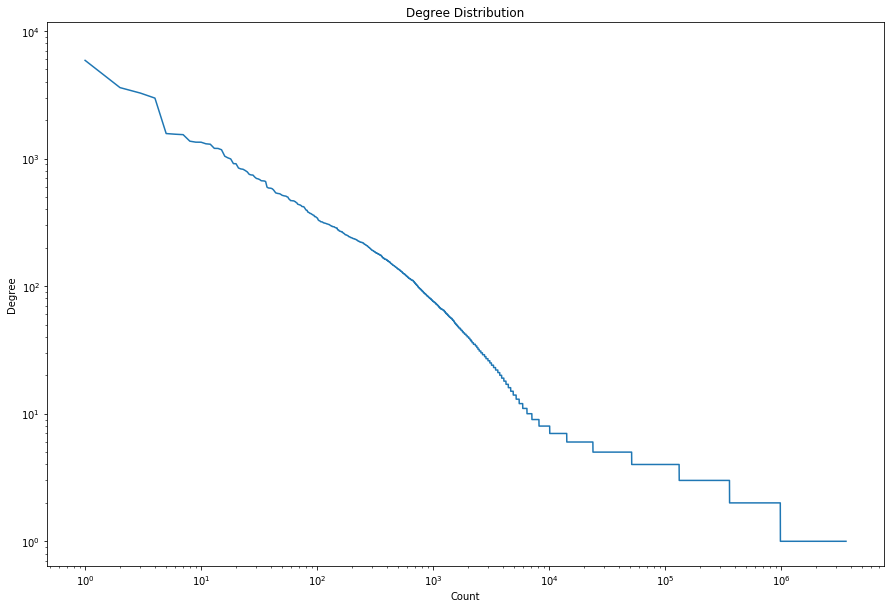

In [77]:
plt.figure(figsize=(15,10))
plt.loglog(degree_sequence)
plt.title('Degree Distribution')
plt.ylabel('Degree')
plt.xlabel('Count')
plt.show()

In [ ]:
nodes_total = set(partner_graph.nodes)
sub_graphs_lables_more2_labled=[]
labeld_data=set(target_wz['partner_nr'])
with open('graph/analyse.txt','w') as f:
    nodes_processed = 0
    for C in nx.connected_component_subgraphs(partner_graph):
        print(nx.info(C),file=f)
        set_nodes = set(C.nodes)
        set_labled = labeld_data.intersection(set_nodes)
        ratio_labled=len(set_labled)/len(set_nodes)
        print('Anteil Labled: ', ratio_labled ,file=f)
        print('average_shortest_path_length',nx.average_shortest_path_length(C),file=f)
        print('------------------',file=f)
        if len(set_labled) > 2:
            sub_graphs_lables_more2_labled.append(C)
        nodes_processed+=len(set_nodes)
        print('Process',nodes_processed/len(nodes_total))

Process 1.1032321945219006e-06
Process 2.482272437674276e-06
Process 3.309696583565702e-06
Process 3.861312680826652e-06
Process 4.688736826718077e-06


In [63]:
type(partner_graph.nodes['isolated'])

dict

In [64]:
#Eine Ehr Lokale untersuchung
node2vec = Node2Vec(partner_graph,walk_length=5,p=1.5,q=0.7,workers=1)
modell_partner = node2vec.fit(window=5,workers=-1, iter=8)

Computing transition probabilities: 100%|██████████| 3625710/3625710 [15:03<00:00, 4012.58it/s] 
0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 10/10 [2:38:24<00:00, 984.61s/it]
1it [3:43:07, 13387.89s/it]


In [99]:
wv_partner=modell_partner.wv

NameError: name 'modell_partner' is not defined

In [100]:
wv_partner=KeyedVectors.load('emb/partner_emb.p')

In [67]:
wv_partner.save('emb/partner_emb.p')

In [105]:
vector_dict={}
for word in target_wz.index:
    try:
        vector_dict[word] = wv_partner.get_vector(word)
    except KeyError:
         vector_dict[word] = wv_partner.get_vector('isolated')
#ectors = list(vector_dict.values())

In [106]:
partner_vec = pd.DataFrame.from_dict(vector_dict, orient='index')

In [116]:
partner_vec.head(3)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
4290392ffe7d0f59a20e5a2645b2ae1c,-0.003848,0.00334,0.000644,-0.000783,-0.000644,0.001681,0.000627,-0.002889,-0.002321,-0.000860,...,0.003496,0.003274,0.003444,0.001635,0.000486,-0.001606,0.001443,0.001428,0.003176,-0.002278
ca525070f389020b42436b4ef5f51722,-0.000468,-0.00127,-0.003217,-0.002587,-0.002832,-0.003815,0.003410,-0.000214,-0.001071,0.003309,...,0.000864,0.001652,0.003830,-0.001691,0.000107,-0.001818,0.003320,-0.000968,0.000936,-0.001852
1aa0928cb4f6ef9f1dc2c55b45c7815f,-0.000468,-0.00127,-0.003217,-0.002587,-0.002832,-0.003815,0.003410,-0.000214,-0.001071,0.003309,...,0.000864,0.001652,0.003830,-0.001691,0.000107,-0.001818,0.003320,-0.000968,0.000936,-0.001852


In [108]:
feature_vec = pd.merge(left = target,right= partner_vec,how='left' ,left_on='partner_nr',right_index=True)
print(feature_vec.shape)
feature_vec.head()

In [112]:
partner_vec_sparse = csr_matrix(feature_vec[list(range(128))].values)

In [114]:
feature_oneHot_withemb=hstack([partner_vec_sparse,features_OneHot])
feature_oneHot_withemb

<95620x4006 sparse matrix of type '<class 'numpy.float64'>'
	with 12607431 stored elements in COOrdinate format>

In [115]:
save_npz('data/DataPartnerEmbed/feature_oneHot_withemb.npz',feature_oneHot_withemb)